In [1]:
# %% [markdown]
# # Measure performance
# This notebook loads a file with precomputed measures (*qmeans*, *qbas* & *qinv*) for a set of rankings for a given instance of the dataset and measures the performance of the different alternative measures
# 
# ## 1. Load libraries, model and data

# %%

# Import the necessary libraries
import sys
import os
PROJ_DIR = os.path.realpath(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.join(PROJ_DIR,'src'))
import xai_faithfulness_experiments_lib_edits as fl
import numpy as np
from typing import Optional
from matplotlib import pyplot as plt

MODEL_NAME = 'resnet50'
REFERENCE_MODEL_NAME = MODEL_NAME#'resnet50w'

referenced_generation_modes = ['_genetic', '_captum']

results = []

for FILENAME in os.listdir(os.path.join(PROJ_DIR,'results')):
    if FILENAME.endswith(f'_measures.npz') and all([generation not in FILENAME for generation in referenced_generation_modes]):
        print(FILENAME)

        results_filename = {'file': FILENAME}

        # Load data
        data = fl.load_generated_data(os.path.join(PROJ_DIR, 'results', FILENAME))
        
        qmeans = data['qmeans']
        #qmeans_basX = [data['qmean_bas']] # We don't look at qmean_bas, it will be recomputed later with the appropriate reference
        qmeans_basX = []
        qmeans_inv = data['qmean_invs']

        data_reference = data
        qmeans_reference = qmeans
        
        # Compute qmeans_bas[2-10]
        def compute_qbas(measure, num_samples, reference:np.ndarray):
            random_indices = np.random.randint(0, measure.shape[0], (measure.shape[0], num_samples))
            random_qmeans = reference[random_indices]
            mean = np.mean(random_qmeans, axis=1)

            # First way to deal with std==0; add some epsilon
            #std = np.std(random_qmeans, axis=1) + 1e-10

            # Second way to deal with std==0; ignore std (divide by 1)
            std = np.std(random_qmeans, axis=1)
            std[std==0] = 1

            # Always ignore std
            std=1
            return (measure - mean) / std

        for i in range(1,11):
            # If data is genetic, compute qbas with random data from other file
            qmeans_basX.append(compute_qbas(qmeans, i, qmeans_reference))

        # Compute z-score
        qmean_mean = np.mean(qmeans)
        qmean_std = np.std(qmeans)

        results_filename['qmean_mean'] = qmean_mean
        results_filename['qmean_std'] = qmean_std
        
        z_scores = ((qmeans - qmean_mean) / qmean_std).flatten()
        
        # Stratify z-index to be able to compare performance on different parts of the spectrum
        indices = np.arange(z_scores.shape[0])
        z_scores_numbered = np.vstack((z_scores, indices))
        level_indices = []
        boundaries = [0.5, 1, 1.5, 2, 2.5, 3, 3.5]
        for i in range(1,len(boundaries)+1):
            bottom_limit = boundaries[i-1]
            top_limit = float('inf')
            if i < len(boundaries):
                top_limit = boundaries[i]
            level_indices.append((z_scores_numbered[:,np.logical_and(bottom_limit<=z_scores, z_scores<top_limit)][1,:].astype(int),(bottom_limit, top_limit)))
        
        def measure_correct_orderings(truths, estimators):
            '''
            Creates len(truth) x,y pairs and computes the fraction of them for which (truths[x]<truths[y] and estimators[x]<estimators[y]) or (truths[x]>truths[y] and estimators[x]>estimators[y])
            Inputs:
                - Truths & estimators contain num_elems floats
            Output:
                - Float representing the fraction of correctly ordered pairings
            '''
            xs = np.random.permutation(truths.size)
            ys = np.random.permutation(truths.size)
            truthX_lt_Y = truths[xs] < truths[ys]
            estimatorX_lt_Y = estimators[xs] < estimators[ys]
            hits = truthX_lt_Y==estimatorX_lt_Y
            return hits.sum()/truths.size
        
        correct_pairings_basX = []
        for i in range(len(qmeans_basX)):
            correct_pairings_basX.append(measure_correct_orderings(qmeans, qmeans_basX[i]))

        correct_pairings_inv = measure_correct_orderings(qmeans, qmeans_inv)
        results_filename['correct_pairings_effect'] = correct_pairings_inv - correct_pairings_basX[0]

        from scipy.stats import spearmanr
        spearman_basX = []
        for i in range(len(qmeans_basX)):
            spearman_basX.append(spearmanr(qmeans, qmeans_basX[i])[0])
        spearman_inv = spearmanr(qmeans, qmeans_inv)[0]
        results_filename['spearman_effect'] = spearman_inv - spearman_basX[0]

        # %%
        from sklearn import metrics

        def measure_detection(target_indices, estimator):
            if (len(target_indices)==0) or (len(target_indices) == estimator.shape[0]):
                return float('nan')
            target = np.zeros_like(estimator, dtype=int)
            target[target_indices] = 1
            return metrics.roc_auc_score(target, estimator)

        aucs_inv = []
        aucs_basX = [[] for i in qmeans_basX]

        for indices, (bottom_limit, upper_limit) in level_indices:
            aucs_inv.append(measure_detection(indices, qmeans_inv))
            for i in range(len(qmeans_basX)):
                aucs_basX[i].append(measure_detection(indices, qmeans_basX[i]))

        results_filename['auc_exceptional_effect'] = list(map(lambda x: x[0]-x[1], zip(aucs_inv, aucs_basX[0])))

        spearman_exceptional_inv = []
        spearman_exceptional_basX = [[] for i in qmeans_basX]

        for indices, (bottom_limit, upper_limit) in level_indices:
            spearman_exceptional_inv.append(spearmanr(qmeans[indices], qmeans_inv[indices])[0])
            for i in range(len(qmeans_basX)):
                spearman_exceptional_basX[i].append(spearmanr(qmeans[indices], qmeans_basX[i][indices])[0])

        results_filename['spearman_exceptional_effect'] = list(map(lambda x: x[0]-x[1], zip(spearman_exceptional_inv, spearman_exceptional_basX[0])))
        results.append(results_filename)

imagenet_22_resnet50_measures.npz
cifar_40_resnet50_measures.npz
20newsgroups-truncated_12__measures.npz
imagenet_61_resnet50_measures.npz
glass_20-untrained_measures.npz
20newsgroups-truncated_22__measures.npz
avila_50-untrained_measures.npz
glass_50_measures.npz
glass_10-ood-zeros_measures.npz
glass_30-ood-mean_measures.npz
avila_10-ood-zeros_measures.npz
mnist_20_ood-mean_softmax_measures.npz
avila_30-untrained_measures.npz
mnist_50_softmax_measures.npz
avila_20-ood-zeros_measures.npz
avila_30-ood-zeros_measures.npz
avila_40-ood-mean_measures.npz
glass_50-untrained_measures.npz
glass_50-ood-zeros_measures.npz
glass_30_measures.npz
20newsgroups-truncated_10__measures.npz
imagenet_20_resnet50_measures.npz
avila_20-untrained_measures.npz
avila_50-undertrained_measures.npz
imagenet_50_resnet50_measures.npz
imagenet_41_resnet50_measures.npz
20newsgroups-truncated_20__measures.npz
imagenet_2_resnet50_measures.npz
imagenet_32_resnet50_measures.npz
avila_20-undertrained_measures.npz
cifar_2

KeyboardInterrupt: 

In [2]:
import pickle
with open(os.path.join(PROJ_DIR, 'results', 'results-per-file.pkl'), 'wb') as fOut:
    pickle.dump(results, fOut)

In [3]:
per_dataset_and_model = {}
for r in results:
    filename = r['file'].replace('-ood','_ood').replace('-undertrained', '_undertrained').replace('-untrained', '_untrained')
    parts = filename.split('_')
    dataset = parts[0]
    model = parts[-2]
    if len(parts) == 3:
        model = ''
    #print(f'{dataset:25s}\t{model:16s}\t({filename})')
    if (dataset + '|' + model) not in per_dataset_and_model:
        per_dataset_and_model[dataset + '|' + model] = []
    per_dataset_and_model[dataset + '|' + model].append((r['spearman_effect'], r['qmean_std']))

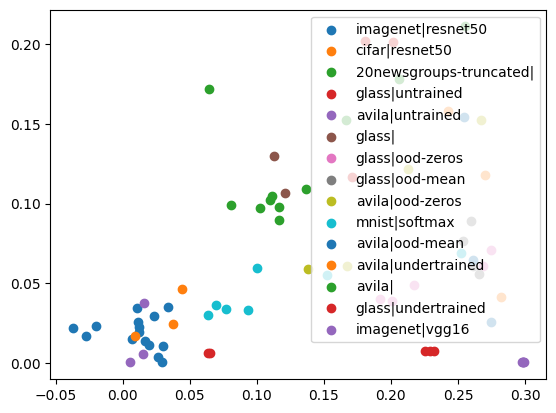

Spearman correlation 0.3306


In [4]:
from matplotlib import pyplot as plt
x = []
y = []
for k in per_dataset_and_model:
    x_k = list(map(lambda x: x[0], per_dataset_and_model[k]))
    y_k = list(map(lambda x: x[1], per_dataset_and_model[k]))
    x += x_k
    y += y_k
    plt.scatter(x_k, y_k, label=k)
plt.legend()
plt.show()
print(f'Spearman correlation {spearmanr(x, y)[0]:.4f}')


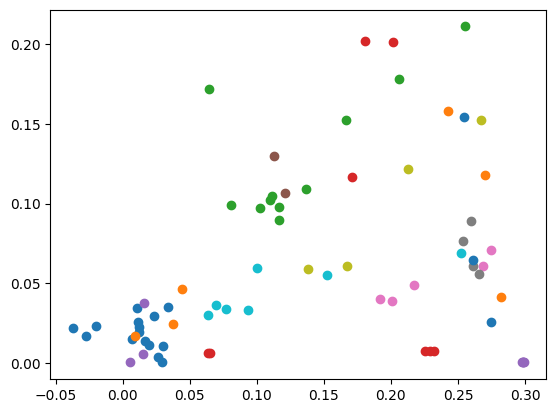

Spearman correlation 0.3306


In [5]:
from matplotlib import pyplot as plt
x = []
y = []
for k in per_dataset_and_model:
    x_k = list(map(lambda x: x[0], per_dataset_and_model[k]))
    y_k = list(map(lambda x: x[1], per_dataset_and_model[k]))
    x += x_k
    y += y_k
    plt.scatter(x_k, y_k, label=k)

plt.show()
print(f'Spearman correlation {spearmanr(x, y)[0]:.4f}')